# 중고 자동차 가격은 무엇으로 결정되는가?

본 분석의 목표는 단순히 가격을 예측하는 것이 아니라,  
영국 중고차 시장에서 차량의 어떤 특성이 가격 형성에 영향을 미치는지를 구조적으로 이해하는 것이다.

연식과 주행거리만으로 설명 가능한지,  
아니면 브랜드와 차량 포지셔닝이 가격에 더 큰 영향을 미치는지를 확인하고자 하였다.

## 데이터 로드

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

car_df = pd.read_csv("cars.csv")
brand_df = pd.read_csv("brand.csv")


In [3]:
# 데이터프레임 확인
car_df.head(10)


,title,Price,Mileage(miles),Registration_Year,Previous Owners,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history
0,SKODA FABIA,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,NaN
1,VAUXHALL CORSA,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full
2,HYUNDAI I30,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,NaN
3,MINI HATCH,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full
4,VAUXHALL CORSA,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,NaN
5,HYUNDAI COUPE,800,124196,2007,3.0,Petrol,Coupe,2.0L,Manual,3.0,4.0,Euro 4,NaN
6,FORD FOCUS,798,140599,2008,NaN,Petrol,Hatchback,1.6L,Manual,5.0,5.0,Euro 4,NaN
7,VAUXHALL CORSA,1995,90000,2009,NaN,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,NaN
8,VOLVO 740,750,225318,2025,NaN,Petrol,Estate,2.3L,Automatic,5.0,NaN,NaN,NaN
9,PEUGEOT 207,1299,87000,2008,5.0,Diesel,Hatchback,1.6L,Manual,5.0,5.0,Euro 4,NaN


In [4]:
brand_df.head(10)

,title,country
0,skoda,Czech Republic
1,vauxhall,United Kingdom
2,hyundai,South Korea
3,mini,United Kingdom
4,ford,United States
5,volvo,Sweden
6,peugeot,France
7,bmw,Germany
8,citroen,France
9,mercedes-benz,Germany


In [5]:
# car_df의 "title"에서 브랜드명만 추출
car_df["title"]= car_df["title"].str.split().str[0].str.lower()

# brand_df랑 병합
car_df = car_df.merge(
    brand_df,
    on="title",
    how="left"
)

car_df.head()

,title,Price,Mileage(miles),Registration_Year,Previous Owners,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history,country
0,skoda,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,NaN,Czech Republic
1,vauxhall,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full,United Kingdom
2,hyundai,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,NaN,South Korea
3,mini,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full,United Kingdom
4,vauxhall,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,NaN,United Kingdom


## EDA

In [6]:
car_df.shape

(3687, 14)

In [7]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3687 entries, 0 to 3686
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              3687 non-null   object 
 1   Price              3687 non-null   int64  
 2   Mileage(miles)     3687 non-null   int64  
 3   Registration_Year  3687 non-null   int64  
 4   Previous Owners    2276 non-null   float64
 5   Fuel type          3687 non-null   object 
 6   Body type          3687 non-null   object 
 7   Engine             3642 non-null   object 
 8   Gearbox            3687 non-null   object 
 9   Doors              3662 non-null   float64
 10  Seats              3652 non-null   float64
 11  Emission Class     3600 non-null   object 
 12  Service history    540 non-null    object 
 13  country            3687 non-null   object 
dtypes: float64(3), int64(3), object(8)
memory usage: 403.4+ KB


In [8]:
car_df.describe()

,Price,Mileage(miles),Registration_Year,Previous Owners,Doors,Seats
count,3687.000000,3.687000e+03,3687.000000,2276.000000,3662.000000,3652.000000
mean,5787.301058,8.132854e+04,2011.846216,2.807557,4.321409,4.900329
std,4480.629885,3.941718e+04,5.082387,1.546028,0.986760,0.577046
min,400.000000,1.000000e+00,1953.000000,1.000000,2.000000,2.000000
25%,2490.000000,5.698400e+04,2008.000000,2.000000,3.000000,5.000000
50%,4000.000000,8.000000e+04,2012.000000,3.000000,5.000000,5.000000
75%,7995.000000,1.030000e+05,2015.500000,4.000000,5.000000,5.000000
max,33900.000000,1.110100e+06,2025.000000,9.000000,5.000000,7.000000


가격, 거리 연식 확인이 필요하다

In [9]:
car_df.isnull().sum()

title                   0
Price                   0
Mileage(miles)          0
Registration_Year       0
Previous Owners      1411
Fuel type               0
Body type               0
Engine                 45
Gearbox                 0
Doors                  25
Seats                  35
Emission Class         87
Service history      3147
country                 0
dtype: int64

이전 소유자와, 엔진, 도어수, 좌석수, 배출가스등급, 정비이력에 결측치가 있음

##  데이터 설명
- Price: 차량 가격
- Mileage(miles): 주행거리
- Registration_Year: 등록 연도
- Previous Owners: 이전 소유자 수
- Fuel type: 연료 종류
- Body type: 차체 유형
- Engine: 배기량
- Gearbox: 변속기 종류
- Emission Class: 배출가스 등급
- Service history: 정비 이력
- country: 브랜드 국가

총 3,687개의 관측치를 포함하고 있으며, 일부 변수에는 결측치가 존재하였다.

## 데이터 전처리

#### Price

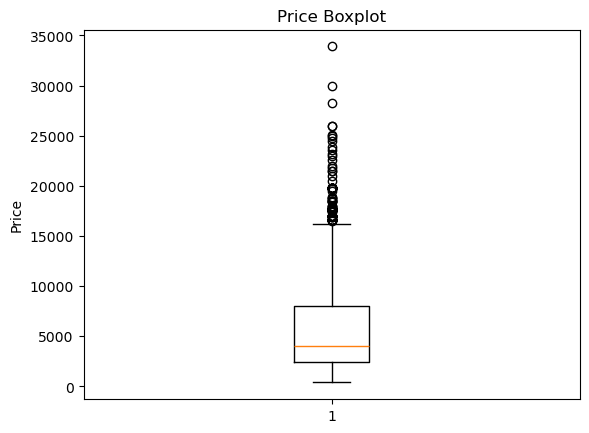

In [10]:
# 가격의 분포 확인
plt.figure()
plt.boxplot(car_df["Price"])
plt.title("Price Boxplot")
plt.ylabel("Price")
plt.show()

고가의 차량이 평균을 왜곡시키니깐 고가의 차량 정보를 확인

In [11]:
# 가격이 높은 10개 행 출력
car_df.sort_values(by="Price", ascending=False).head(10)

,title,Price,Mileage(miles),Registration_Year,Previous Owners,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history,country
3212,mercedes-benz,33900,92000,2019,1.0,Diesel,SUV,2.0L,Automatic,5.0,5.0,Euro 6,NaN,Germany
2936,land,30000,46000,2017,2.0,Diesel,SUV,2.0L,Automatic,5.0,5.0,Euro 6,NaN,United Kingdom
3224,bmw,28240,45155,2019,1.0,Diesel,SUV,2.0L,Automatic,5.0,5.0,Euro 6,NaN,Germany
3230,land,25995,36363,2015,NaN,Diesel,SUV,3.0L,Automatic,5.0,5.0,Euro 5,NaN,United Kingdom
3102,seat,25995,222,2023,NaN,Petrol,SUV,1.5L,Manual,5.0,5.0,Euro 6,NaN,Spain
2913,land,25100,26994,2019,NaN,Diesel,SUV,2.0L,Manual,5.0,5.0,Euro 6,NaN,United Kingdom
3130,audi,25000,34364,2019,1.0,Diesel,Estate,2.0L,Automatic,5.0,5.0,Euro 6,NaN,Germany
2183,ds,24770,16864,2021,1.0,Petrol Plug-in Hybrid,Saloon,1.6L,Automatic,4.0,5.0,Euro 6,NaN,France
2862,land,24444,22189,2019,NaN,Diesel,SUV,2.0L,Manual,5.0,5.0,Euro 6,NaN,United Kingdom
3213,mazda,23910,23178,2020,1.0,Petrol,Estate,2.5L,Automatic,5.0,5.0,Euro 6,NaN,Japan


이상치는 아닌것 같아서 로그변환으로 왜곡을 줄인다.

In [12]:
# 로그 변환
car_df["log_Price"] = np.log(car_df["Price"])

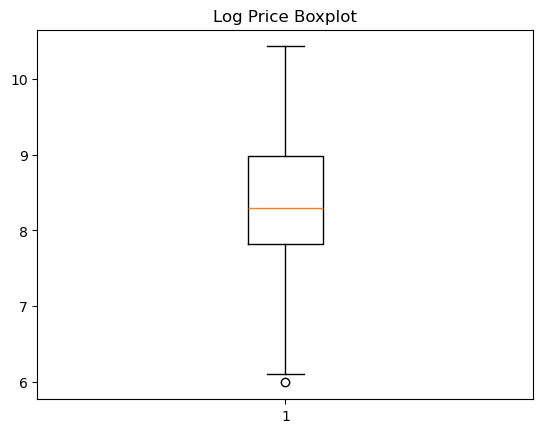

In [13]:
# 박스플롯
plt.figure()
plt.boxplot(car_df["log_Price"])
plt.title("Log Price Boxplot")
plt.show()

#### Mileage

In [14]:
# 기본 정보
car_df["Mileage(miles)"].describe()

count    3.687000e+03
mean     8.132854e+04
std      3.941718e+04
min      1.000000e+00
25%      5.698400e+04
50%      8.000000e+04
75%      1.030000e+05
max      1.110100e+06
Name: Mileage(miles), dtype: float64

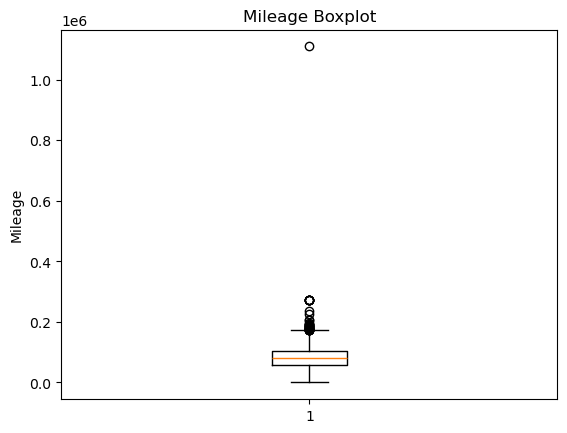

In [15]:
# 박스플롯 확인
plt.figure()
plt.boxplot(car_df["Mileage(miles)"])
plt.title("Mileage Boxplot")
plt.ylabel("Mileage")
plt.show()

In [16]:
# 상위 5개만 확인해서 1위값을 제거
car_df.sort_values(
    by="Mileage(miles)",
    ascending=False
).head(5)

,title,Price,Mileage(miles),Registration_Year,Previous Owners,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history,country,log_Price
1037,volkswagen,2495,1110100,2003,4.0,Petrol,Hatchback,2.0L,Automatic,3.0,4.0,Euro 4,NaN,Germany,7.822044
2048,volvo,795,274100,2004,6.0,Petrol,Estate,2.4L,Automatic,5.0,5.0,Euro 3,NaN,Sweden,6.678342
1478,volvo,795,274100,2004,6.0,Petrol,Estate,2.4L,Automatic,5.0,5.0,Euro 3,NaN,Sweden,6.678342
1259,volvo,795,274100,2004,6.0,Petrol,Estate,2.4L,Automatic,5.0,5.0,Euro 3,NaN,Sweden,6.678342
1685,volvo,795,274100,2004,6.0,Petrol,Estate,2.4L,Automatic,5.0,5.0,Euro 3,NaN,Sweden,6.678342


In [17]:
# 100만 마일 이상 제거
car_df = car_df[car_df["Mileage(miles)"] < 1000000]

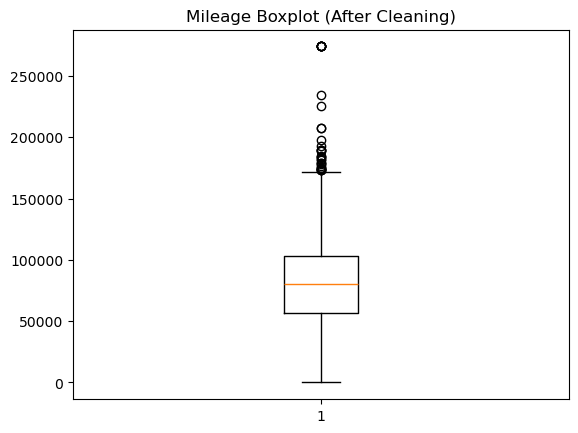

In [18]:
# 제거 후 박스플롯
plt.figure()
plt.boxplot(car_df["Mileage(miles)"])
plt.title("Mileage Boxplot (After Cleaning)")
plt.show()

제거 후에도 이상치가 있었지만 일단 두기로 함

#### Registration_Year

In [19]:
# 기본 정보
car_df["Registration_Year"].describe()

count    3686.000000
mean     2011.848616
std         5.080987
min      1953.000000
25%      2008.000000
50%      2012.000000
75%      2015.750000
max      2025.000000
Name: Registration_Year, dtype: float64

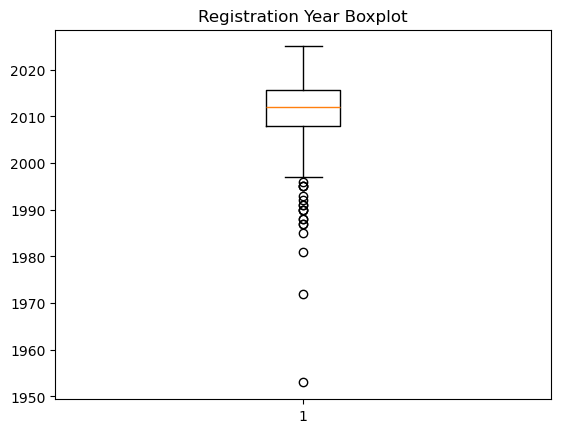

In [20]:
# 박스플롯 확인
plt.figure()
plt.boxplot(car_df["Registration_Year"])
plt.title("Registration Year Boxplot")
plt.show()

In [21]:
# 1990년 이전에 등록한 중고차 확인
car_df[car_df["Registration_Year"] < 1990] \
    .sort_values(by="Registration_Year", ascending=False)

,title,Price,Mileage(miles),Registration_Year,Previous Owners,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history,country,log_Price
1173,volkswagen,2500,124000,1988,7.0,Petrol,Hatchback,1.8L,Automatic,5.0,5.0,NaN,NaN,Germany,7.824046
3116,volkswagen,7000,130000,1988,1.0,Petrol,Convertible,1.8L,Manual,2.0,NaN,NaN,NaN,Germany,8.853665
1195,porsche,6750,121000,1987,7.0,Petrol,Coupe,2.5L,Manual,2.0,4.0,NaN,NaN,Germany,8.817298
1353,bmw,3495,115000,1987,4.0,Petrol,Saloon,1.8L,Automatic,4.0,NaN,NaN,NaN,Germany,8.159089
1239,nissan,999,60000,1985,NaN,Petrol,Saloon,1.3L,Manual,4.0,NaN,NaN,NaN,Japan,6.906755
2375,marcos,11495,19000,1981,5.0,Petrol,Convertible,2.0L,Manual,NaN,2.0,NaN,NaN,United Kingdom,9.349667
237,mg,1875,75043,1972,3.0,Petrol,Convertible,1.3L,Manual,2.0,NaN,NaN,NaN,United Kingdom,7.536364
3024,lagonda,14995,84000,1953,NaN,Petrol,Saloon,2.6L,Manual,4.0,NaN,NaN,NaN,United Kingdom,9.615472


Emission Class와 Service history도 없고, 너무 오래된 데이터 같아서 그냥 제거하고 일반 중고차 시장을 분석 하려고 함.

In [22]:
car_df = car_df[car_df["Registration_Year"] >= 1990]

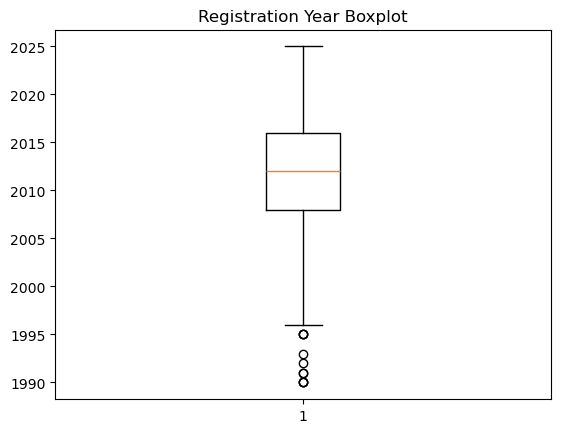

In [23]:
# 제거 후 
plt.figure()
plt.boxplot(car_df["Registration_Year"])
plt.title("Registration Year Boxplot")
plt.show()

In [24]:
car_df.isnull().sum()

title                   0
Price                   0
Mileage(miles)          0
Registration_Year       0
Previous Owners      1409
Fuel type               0
Body type               0
Engine                 45
Gearbox                 0
Doors                  24
Seats                  30
Emission Class         79
Service history      3138
country                 0
log_Price               0
dtype: int64

#### Previous Owners

In [25]:
car_df["Previous Owners"].describe()

count    2269.000000
mean        2.802556
std         1.541825
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         9.000000
Name: Previous Owners, dtype: float64

In [26]:
# 값 분포 확인
car_df["Previous Owners"].value_counts().sort_index()

Previous Owners
1.0    522
2.0    594
3.0    474
4.0    358
5.0    207
6.0     60
7.0     37
8.0     12
9.0      5
Name: count, dtype: int64

<Axes: >

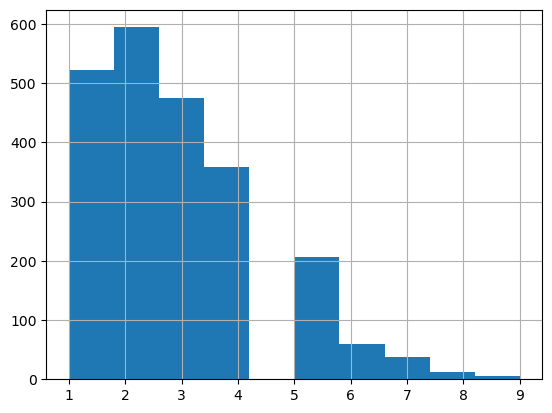

In [27]:
# 분포 확인
car_df["Previous Owners"].hist(bins=10)

In [28]:
# 평균과 중앙값 확인
print("평균:", car_df["Previous Owners"].mean())
print("중앙값:", car_df["Previous Owners"].median())

평균: 2.8025561921551345
중앙값: 3.0


In [29]:
# 중앙값으로 대체
median_owner = car_df["Previous Owners"].median()
car_df["Previous Owners"] = car_df["Previous Owners"].fillna(median_owner)

#### Engine


In [30]:
car_df["Engine"].describe()

count     3633
unique      34
top       1.6L
freq       736
Name: Engine, dtype: object

In [31]:
# 숫자형 변환
car_df["Engine"] = (
    car_df["Engine"]
    .str.replace("L", "", regex=False)
    .astype(float)
)

In [32]:
car_df["Engine"].describe()
car_df["Engine"].dtype

dtype('float64')

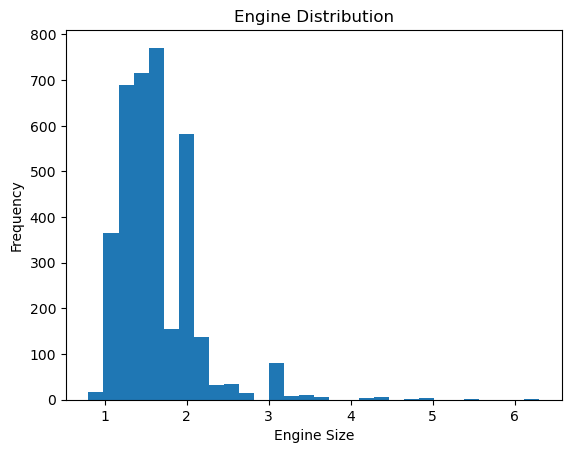

In [33]:
# 분포 확인
plt.figure()
plt.hist(car_df["Engine"], bins=30)
plt.title("Engine Distribution")
plt.xlabel("Engine Size")
plt.ylabel("Frequency")
plt.show()

In [34]:
# 결측치 중앙값 대체
car_df["Engine"] = car_df["Engine"].fillna(
    car_df["Engine"].median()
)

#### Emission Class

In [35]:
car_df["Emission Class"].value_counts()

Emission Class
Euro 5    1257
Euro 6    1109
Euro 4    1067
Euro 3     137
Euro 2      25
Euro 1       4
Name: count, dtype: int64

In [36]:
# 숫자만 추출
car_df["Emission Class"] = (
    car_df["Emission Class"]
    .str.split()
    .str[-1]
    .astype(float)
)

In [37]:
car_df["Emission Class"].describe()

count    3599.000000
mean        4.910253
std         0.910688
min         1.000000
25%         4.000000
50%         5.000000
75%         6.000000
max         6.000000
Name: Emission Class, dtype: float64

In [38]:
car_df["Emission Class"].value_counts().sort_index()

Emission Class
1.0       4
2.0      25
3.0     137
4.0    1067
5.0    1257
6.0    1109
Name: count, dtype: int64

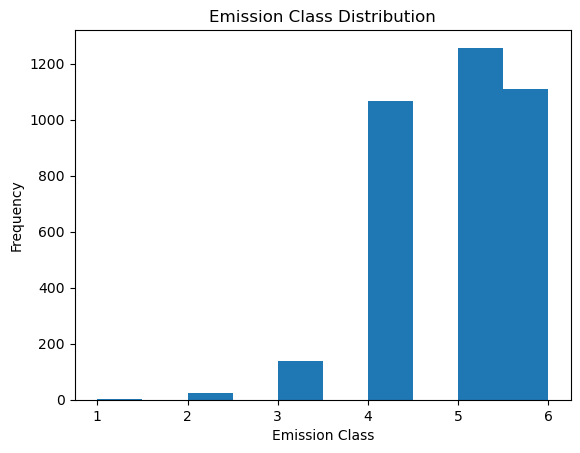

In [39]:
# 히스토그램
plt.figure()
plt.hist(car_df["Emission Class"], bins=10)
plt.title("Emission Class Distribution")
plt.xlabel("Emission Class")
plt.ylabel("Frequency")
plt.show()

In [40]:
# 결측치 삭제
car_df = car_df.dropna(subset=["Emission Class"])

#### Doors, Seats

In [41]:
# 누락 정보 같고 개수도 적어서 삭제
car_df = car_df.dropna(subset=["Doors", "Seats"])

#### Service history

결측치 행의 개수가 많고 중요한 정보 같아서 Unknown으로 변경

In [42]:
# Unknown으로 변경
car_df["Service history"] = car_df["Service history"].fillna("Unknown")

In [43]:
car_df.isnull().sum()

title                0
Price                0
Mileage(miles)       0
Registration_Year    0
Previous Owners      0
Fuel type            0
Body type            0
Engine               0
Gearbox              0
Doors                0
Seats                0
Emission Class       0
Service history      0
country              0
log_Price            0
dtype: int64

결측치 제거 완료

## 상관관계 분석

In [44]:
# 상관관계 분석
corr = car_df[
    [
        "log_Price",
        "Mileage(miles)",
        "Registration_Year",
        "Previous Owners",
        "Engine",
        "Doors",
        "Seats",
        "Emission Class"
    ]
].corr()

corr

,log_Price,Mileage(miles),Registration_Year,Previous Owners,Engine,Doors,Seats,Emission Class
log_Price,1.000000,-0.574846,0.812278,-0.412088,-0.025152,0.110338,-0.040074,0.758278
Mileage(miles),-0.574846,1.000000,-0.479171,0.286425,0.362871,-0.025965,0.118472,-0.414404
Registration_Year,0.812278,-0.479171,1.000000,-0.410695,-0.295867,0.212885,0.025658,0.918903
Previous Owners,-0.412088,0.286425,-0.410695,1.000000,0.143242,-0.120289,-0.023189,-0.378609
Engine,-0.025152,0.362871,-0.295867,0.143242,1.000000,-0.059910,0.072878,-0.262352
Doors,0.110338,-0.025965,0.212885,-0.120289,-0.059910,1.000000,0.497646,0.177235
Seats,-0.040074,0.118472,0.025658,-0.023189,0.072878,0.497646,1.000000,0.022110
Emission Class,0.758278,-0.414404,0.918903,-0.378609,-0.262352,0.177235,0.022110,1.000000


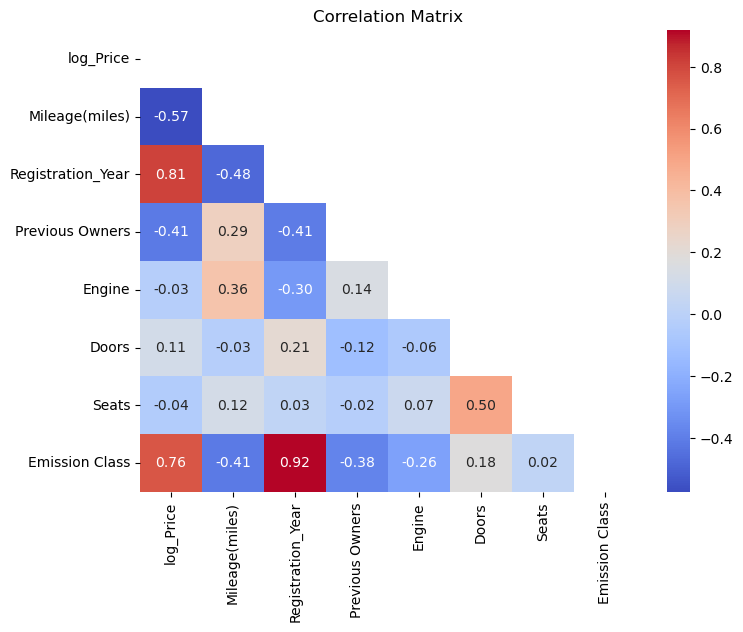

In [45]:
# 히트맵으로 시각화
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", mask=mask)
plt.title("Correlation Matrix")
plt.show()

다음 변수들은 log_Price와 비교적 큰 상관관계를 보였다:

	•	Registration_Year (0.81)
	•	Emission Class (0.76)
	•	Mileage (-0.57)
	•	Previous Owners (-0.41)

차량이 최신, 배출가스 등급이 높으면 가격이 높고, 주행거리와 소유자가 많으면 가격이 낮아지는 경향이 있다.

Emission Class랑 Registration_Year은 다중공선성 문제로 Emission Class 제거

Engine, Door, Seat는 가격과 상관관계가 작아서 제거

## 스케일링

In [46]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

In [47]:
ss = StandardScaler()
rs = RobustScaler()
mm = MinMaxScaler()

In [48]:
# 스케일링 할 변수
features = [
    "Mileage(miles)",
    "Registration_Year",
    "Previous Owners"
]

X = car_df[features]
y = car_df["log_Price"]

In [49]:
# 진행
X_scaled = ss.fit_transform(X)

In [50]:
pd.DataFrame(X_scaled, columns=features).describe()

,Mileage(miles),Registration_Year,Previous Owners
count,3593.000000,3.593000e+03,3593.000000
mean,0.000000,-2.051932e-14,0.000000
std,1.000139,1.000139e+00,1.000139
min,-2.280325,-4.000720e+00,-1.539261
25%,-0.680466,-8.350692e-01,-0.719554
50%,-0.034267,9.104293e-03,0.100153
75%,0.611482,8.532778e-01,0.100153
max,5.415297,2.330581e+00,5.018397


## PCA

In [51]:
# PCA분석
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

cum_explained = np.cumsum(pca.explained_variance_ratio_)
cum_explained

array([0.59646123, 0.83619264, 1.        ])

PC 2개면 83.6% 설명

In [52]:
pca = PCA(2)
X_pca = pca.fit_transform(X_scaled)

In [53]:
X_pca.shape

(3593, 2)

In [54]:
pd.DataFrame(
    pca.components_,
    columns=features,
    index=["PC1", "PC2"]
)

,Mileage(miles),Registration_Year,Previous Owners
PC1,-0.571985,0.624126,-0.532259
PC2,-0.607018,0.114355,0.786417


## 가격 예측 모델

초기 모델에서는 연식과 주행거리만을 사용하였다.

결과는 나쁘지 않았지만, 설명력은 제한적이었다.

In [55]:
# 학습/테스트 데이터 분리
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42
)

In [56]:
# 선형회귀 모델 학습
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [57]:
# 예측
y_pred = model.predict(X_test)

In [58]:
# 성능 평가
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R²:", r2)
print("RMSE:", rmse)

R²: 0.6404823862770295
RMSE: 0.46544091983887437


64% 설명에 오차가 좀 크네

In [59]:
# 랜덤포레스트 모델 학습
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)

rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [60]:
# 성능 평가
from sklearn.metrics import r2_score, mean_squared_error

y_pred_rf = rf.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("R² (RF):", r2_rf)
print("RMSE (RF):", rmse_rf)

R² (RF): 0.6818063398541978
RMSE (RF): 0.43787508748318654


## 범주형 변수(ex.브랜드 별 가격, 차체 등) 확인


브랜드별 가격을 확인해보니  
명확한 가격 구간 차이가 존재했다.

BMW, Mercedes-Benz와 같은 브랜드는 높은 가격대를 형성하고 있었고,  
일부 브랜드는 상대적으로 낮은 가격대에 분포하고 있었다.

이를 단순한 범주형 변수로 두는 대신  
가격 기준으로 HIGH / MID / LOW 세 단계로 그룹화하였다.

이를 통해 중고차 가격은 단순 감가가 아니라  
'브랜드 가치'라는 구조적 요소를 포함하고 있음을 확인하였다.

### title

브랜드 별 가격에 차이가 있나 확인

In [61]:
# 브랜드 별 가격 차이
car_df.groupby("title")["Price"].median().sort_values(ascending=False)

title
ds               14025.0
maserati         13900.0
abarth           11699.0
ssangyong         8636.0
jaguar            8490.0
mg                8198.0
infiniti          7999.0
land              7600.0
kia               7494.5
audi              6999.0
mini              6480.0
bmw               6285.0
skoda             5999.0
dacia             5997.5
mercedes-benz     5995.0
nissan            5940.0
smart             5497.5
porsche           4802.5
volkswagen        4575.0
renault           4000.0
fiat              3995.0
hyundai           3990.0
lexus             3950.0
mazda             3799.0
peugeot           3652.0
ford              3495.0
citroen           3495.0
toyota            3290.0
dodge             3250.0
vauxhall          3195.0
seat              3095.0
suzuki            3000.0
volvo             2995.0
chevrolet         2772.0
honda             2492.5
alfa              2469.5
subaru            2395.0
rover             2299.0
saab              2274.5
chrysler          2

In [62]:
# 브랜드별 평균 vs 중앙값 비교
brand_stats = car_df.groupby("title")["Price"].agg(["mean", "median"])
brand_stats = brand_stats.sort_values("median", ascending=False)

brand_stats.head(10)

,mean,median
title,,
ds,14293.833333,14025.0
maserati,13300.000000,13900.0
abarth,11216.333333,11699.0
ssangyong,8636.000000,8636.0
jaguar,8704.241379,8490.0
mg,9984.555556,8198.0
infiniti,8625.714286,7999.0
land,10741.428571,7600.0
kia,7733.073171,7494.5


In [63]:
# 평균-중앙값 차이
brand_stats["diff"] = brand_stats["mean"] - brand_stats["median"]

brand_stats.sort_values("diff", ascending=False).head(10)

,mean,median,diff
title,,,
land,10741.428571,7600.0,3141.428571
suzuki,5076.853659,3000.0,2076.853659
bmw,8354.840909,6285.0,2069.840909
volkswagen,6576.061303,4575.0,2001.061303
toyota,5280.310160,3290.0,1990.310160
peugeot,5463.955102,3652.0,1811.955102
mg,9984.555556,8198.0,1786.555556
mercedes-benz,7747.066667,5995.0,1752.066667
seat,4776.627119,3095.0,1681.627119


In [64]:
# 브랜드별 중간값 계산
brand_median = car_df.groupby("title")["Price"].median()

# 분위수 구하기
q1 = brand_median.quantile(0.33)
q2 = brand_median.quantile(0.66)

# HIGH/MID/LOW 분류
def classify_brand(x):
    if brand_median[x] <= q1:
        return "LOW"
    elif brand_median[x] <= q2:
        return "MID"
    else:
        return "HIGH"

car_df["brand_level"] = car_df["title"].apply(classify_brand)

In [65]:
# 더미변수 생성
brand_level_dummies = pd.get_dummies(
    car_df["brand_level"],
    prefix="brand",
    drop_first=True
)

In [66]:
car_df.head()

,title,Price,Mileage(miles),Registration_Year,Previous Owners,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history,country,log_Price,brand_level
0,skoda,6900,70189,2016,3.0,Diesel,Hatchback,1.4,Manual,5.0,5.0,6.0,Unknown,Czech Republic,8.839277,HIGH
1,vauxhall,1495,88585,2008,4.0,Petrol,Hatchback,1.2,Manual,3.0,5.0,4.0,Full,United Kingdom,7.309881,MID
2,hyundai,949,137000,2011,3.0,Petrol,Hatchback,1.4,Manual,5.0,5.0,5.0,Unknown,South Korea,6.855409,MID
3,mini,2395,96731,2010,5.0,Petrol,Hatchback,1.4,Manual,3.0,4.0,4.0,Full,United Kingdom,7.781139,HIGH
4,vauxhall,1000,85000,2013,3.0,Diesel,Hatchback,1.3,Manual,5.0,5.0,5.0,Unknown,United Kingdom,6.907755,MID


### Body type

In [67]:
# 차체에 따른 분류
car_df.groupby("Body type")["Price"].median().sort_values(ascending=False)

Body type
Pickup         13995.0
SUV             7495.0
Coupe           6000.0
Saloon          4847.5
Estate          4300.0
Convertible     3995.0
Hatchback       3495.0
MPV             3000.0
Combi Van       2495.0
Name: Price, dtype: float64

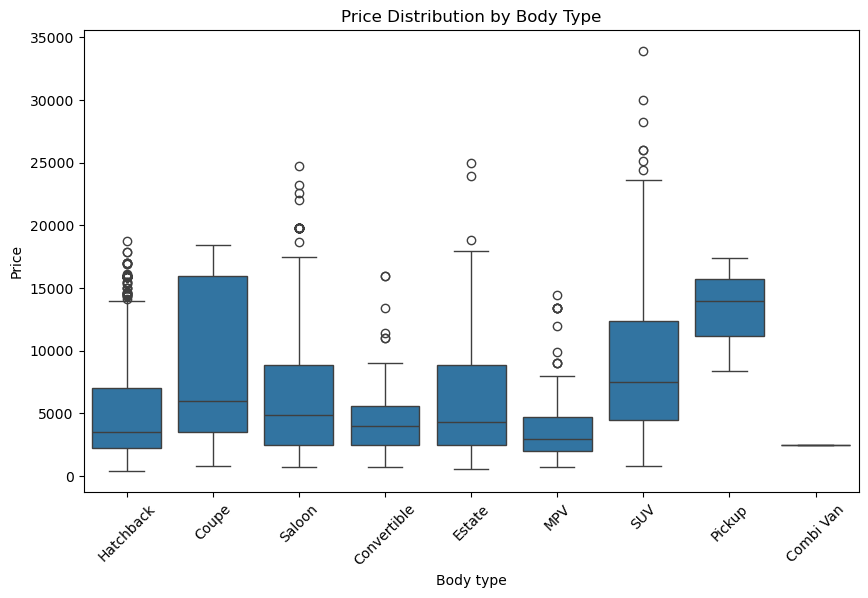

In [68]:
# 시각화
plt.figure(figsize=(10,6))
sns.boxplot(data=car_df, x="Body type", y="Price")
plt.xticks(rotation=45)
plt.title("Price Distribution by Body Type")
plt.show()

In [69]:
# 더미 변수로 생성
body_dummies = pd.get_dummies(
    car_df["Body type"],
    prefix="body",
    drop_first=True
)

## 가격 예측 모델2

In [70]:
# 수치형만 스케일링
X_num = car_df[["Mileage(miles)", "Registration_Year", "Previous Owners"]]

X_num_scaled = ss.fit_transform(X_num)
X_num_scaled = pd.DataFrame(
    X_num_scaled,
    columns=X_num.columns,
    index=car_df.index
)

# 더미랑 합치기
X = pd.concat(
    [
        X_num_scaled,
        body_dummies,
        brand_level_dummies
    ],
    axis=1
)

y = car_df["log_Price"]

In [71]:
# Train/Test 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [72]:
# 선형회귀 학습
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [73]:
# 예측
y_pred = model.predict(X_test)

In [74]:
# 성능 평가

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R²:", r2)
print("RMSE:", rmse)

R²: 0.7831636639248043
RMSE: 0.3614685409593598


78% 설명, 오차 43%

In [75]:
# 회귀계수 계산
coef_df = pd.DataFrame({
    "Variable": X.columns,
    "Coefficient": model.coef_
})

coef_df = coef_df.sort_values(by="Coefficient", ascending=False)
coef_df

,Variable,Coefficient
1,Registration_Year,0.502865
8,body_Pickup,0.443408
2,Previous Owners,-0.056233
4,body_Coupe,-0.136664
10,body_Saloon,-0.159743
0,Mileage(miles),-0.214271
9,body_SUV,-0.229204
3,body_Convertible,-0.257606
5,body_Estate,-0.308849
12,brand_MID,-0.324763


In [76]:
# 랜덤포레스트 모델
rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
)

rf.fit(X_train, y_train)

,n_estimators,300
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [77]:
# 예측
y_pred_rf = rf.predict(X_test)

In [78]:
# 성능 평가
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("R² (RF):", r2_rf)
print("RMSE (RF):", rmse_rf)

R² (RF): 0.8062137676829222
RMSE (RF): 0.341716488967886


## 교차검증

In [79]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    rf,
    X,
    y,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

print("각 Fold R²:", scores)
print("평균 R²:", scores.mean())
print("표준편차:", scores.std())

각 Fold R²: [0.80551682 0.75700927 0.6921449  0.75896565 0.75877828]
평균 R²: 0.7544829843272475
표준편차: 0.0361536037069063


## 하이퍼파라미터 튜닝

In [87]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "max_depth": [None, 10, 15, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", 0.7, 1.0]
}

rf_base = RandomForestRegressor(
    n_estimators=150,   # 탐색용 (가볍게)
    random_state=42,
    n_jobs=-1
)

rs = RandomizedSearchCV(
    rf_base,
    param_distributions=param_dist,
    n_iter=12,
    cv=3,
    scoring="r2",
    n_jobs=-1,
    random_state=42
)

rs.fit(X, y)

print("Best Params:", rs.best_params_)
print("Best CV R²:", rs.best_score_)

Best Params: {'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 0.7, 'max_depth': None}
Best CV R²: 0.7562883083236819


거의 차이 없음

In [88]:
best_params = rs.best_params_

rf_final = RandomForestRegressor(
    **best_params,
    n_estimators=400,   # 최종 모델은 크게
    random_state=42,
    n_jobs=-1
)

rf_final.fit(X_train, y_train)
y_pred = rf_final.predict(X_test)

from sklearn.metrics import r2_score, mean_squared_error

print("Final R²:", r2_score(y_test, y_pred))
print("Final RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

Final R²: 0.8177195773698165
Final RMSE: 0.3314167768890197


## 연료나 다른 정보도 확인
차체 유형과 연료 타입을 추가로 분석했다.

SUV와 Pickup은 상대적으로 높은 가격을 형성했고,  
Hatchback은 낮은 가격 구간에 많이 분포했다.

또한 하이브리드 차량은 높은 가격대를 형성하는 경향을 보였다.

차량이 사용 목적과 포지셔닝에 따라 시장에서 다른 가치를 가진다는 점을 보여준다.

### Fuel type

In [80]:
car_df.groupby("Fuel type")["Price"].median().sort_values(ascending=False)

Fuel type
Diesel Hybrid            23220.0
Petrol Plug-in Hybrid    19800.0
Petrol Hybrid            13000.0
Diesel                    5446.5
Petrol                    3495.0
Name: Price, dtype: float64

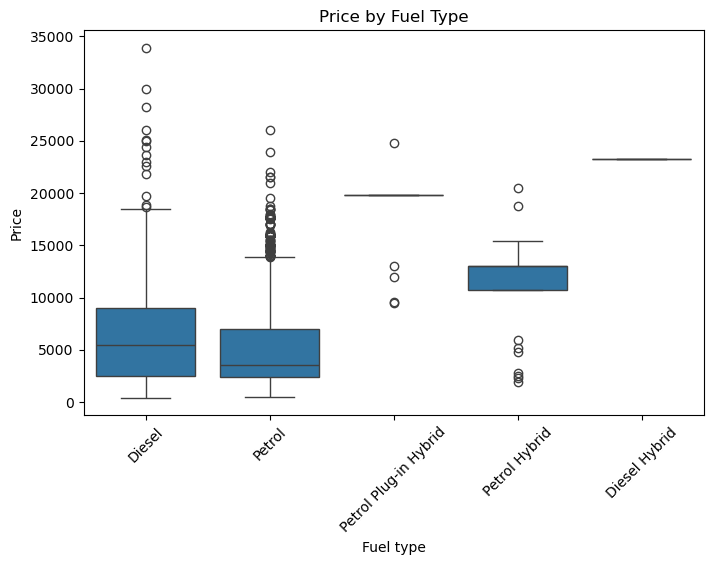

In [81]:
plt.figure(figsize=(8,5))
sns.boxplot(data=car_df, x="Fuel type", y="Price")
plt.xticks(rotation=45)
plt.title("Price by Fuel Type")
plt.show()

### Gearbox

In [82]:
car_df.groupby("Gearbox")["Price"].median().sort_values(ascending=False)

Gearbox
Automatic    5000.0
Manual       3900.0
Name: Price, dtype: float64

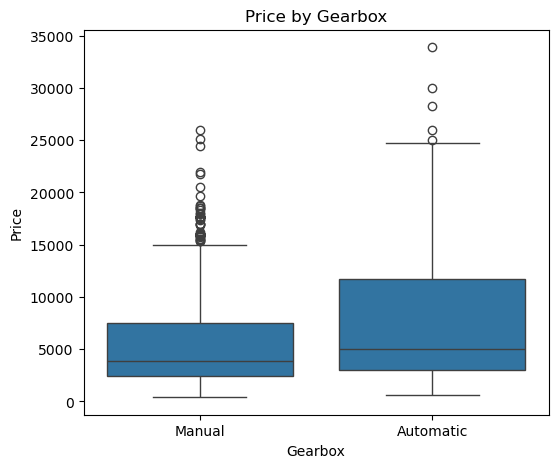

In [83]:
plt.figure(figsize=(6,5))
sns.boxplot(data=car_df, x="Gearbox", y="Price")
plt.title("Price by Gearbox")
plt.show()

### Engine

In [84]:
car_df.groupby("Engine")["Price"].median().sort_values(ascending=False).head(10)

Engine
6.3    10850.0
5.5    10000.0
4.2     9500.0
1.5     9200.0
0.9     6990.0
1.0     6850.0
2.0     5469.5
3.0     5250.0
2.1     4999.5
2.3     4800.0
Name: Price, dtype: float64

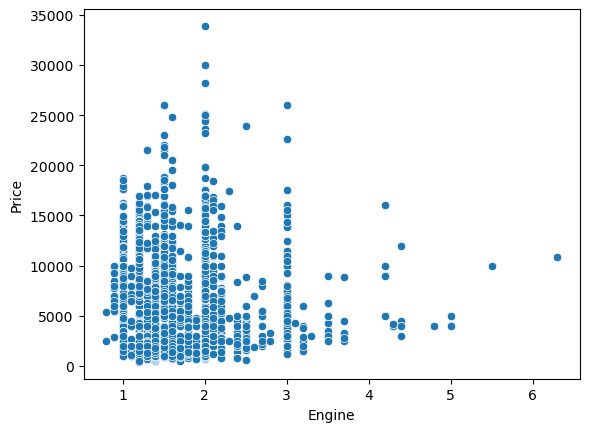

In [85]:
sns.scatterplot(data=car_df, x="Engine", y="Price")
plt.show()

In [86]:
car_df.head()

,title,Price,Mileage(miles),Registration_Year,Previous Owners,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history,country,log_Price,brand_level
0,skoda,6900,70189,2016,3.0,Diesel,Hatchback,1.4,Manual,5.0,5.0,6.0,Unknown,Czech Republic,8.839277,HIGH
1,vauxhall,1495,88585,2008,4.0,Petrol,Hatchback,1.2,Manual,3.0,5.0,4.0,Full,United Kingdom,7.309881,MID
2,hyundai,949,137000,2011,3.0,Petrol,Hatchback,1.4,Manual,5.0,5.0,5.0,Unknown,South Korea,6.855409,MID
3,mini,2395,96731,2010,5.0,Petrol,Hatchback,1.4,Manual,3.0,4.0,4.0,Full,United Kingdom,7.781139,HIGH
4,vauxhall,1000,85000,2013,3.0,Diesel,Hatchback,1.3,Manual,5.0,5.0,5.0,Unknown,United Kingdom,6.907755,MID
